# This notebook explores the use of an RNN model for predicting beaching locations with the Asia watershed

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [3]:
# dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tqdm

from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(style = 'whitegrid', font_scale = 2.5)

In [4]:
# load data
Asia = pd.read_csv('drifter_data/cluster_16_data.csv').drop(columns = 'HDBSCAN')

## Let's look at our dataset: Asia Beaching Watershed

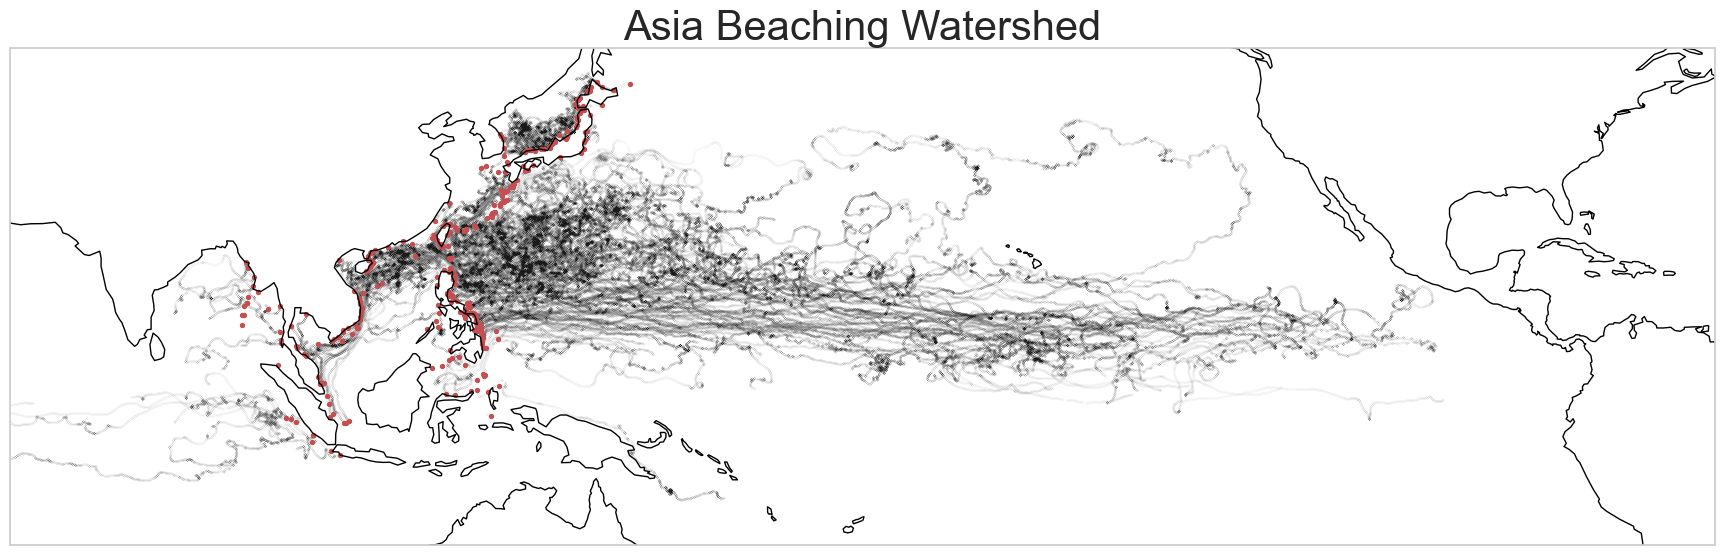

In [6]:
# take a look at the drifter trajectories and beaching locations
beach = Asia
beaching_points = Asia.drop_duplicates(subset='id', keep='last')

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([120, -120, -20, 50], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = ax.scatter(
    beach['lon'],
    beach['lat'],
    marker='o',
    c='k',
    cmap='viridis',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=0.7
)

ax.scatter(beaching_points['lon'], beaching_points['lat'], color='r', transform=ccrs.PlateCarree(), s = 8)  # Specify the coordinate reference system

plt.title('Asia Beaching Watershed', fontsize = 30)
plt.show()

## Let's prepare and clean our data by: 
## 1. Applying a coordinate transform and normalizing 
## 2. Converting into tensors and padding 
## 3. Splitting into train, test, validation, and target
##
### Let's start with 1.

We first need to solve the spatial problem inherent to latitude/longitude coordinate data. The distance between one degree of longitude and another is greatest at the equator and smallest at the poles: in fact, as one approaches the poles, the distance in a degree of longitude gets exponentially small. Another problem is that -180 degrees longitude is equal to 180 degrees longitude, this is far from helpful to a neural network. How do we normalize this kind of data? Let's apply a coordinate transform, converting latitude and longitude to the x, y, z coordinates of a sphere (we make the assumption the Earth is a perfect sphere, it isn't, but this shouldn't impact our results in any significant way). The next block of code defines a function to achieve this transformation and shows a 2-d lat/lon map before and 3-d x,y,z sphere after.

In [9]:
# we define a function to transform lat/lon to x,y,z and normalize while we're at it
def coord_transform_normalize(lat_list, lon_list, scaler):
    
    # convert to radians for use of np.cos, np.sin
    lats_r, lons_r = np.radians(lat_list), np.radians(lon_list)
    
    # transform lat/lon to x, y, z
    x = np.cos(lons_r) * np.cos(lats_r)
    y = np.sin(lons_r) * np.cos(lats_r) 
    z = np.sin(lats_r) 
    
    # stack x,y,z coords
    xyz_coords = np.column_stack((x, y, z))
    
    # fit scaler to the coords and apply normalization
    norm_xyz_coords = scaler.fit_transform(xyz_coords)
    
    # split back into x,y,z
    norm_x, norm_y, norm_z = np.hsplit(norm_xyz_coords, 3)

    return norm_x, norm_y, norm_z

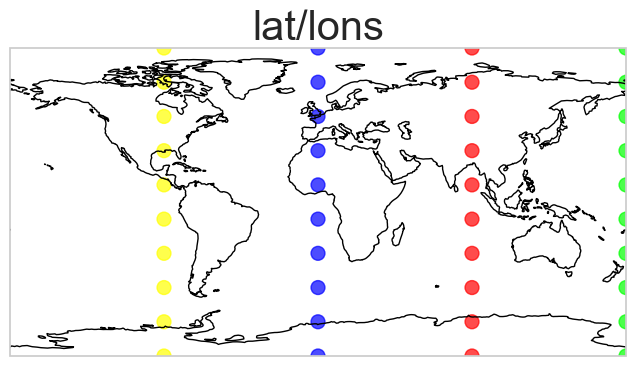

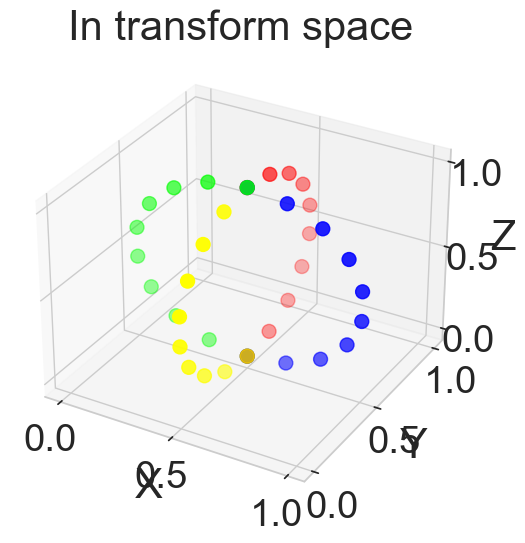

In [11]:
# now we apply this transform to some toy lat/lons:
toy_latitudes_1 = np.array(np.linspace(-90,90,10))
toy_longitudes_1 = np.array(np.ones(10) * 90)
                              
toy_latitudes_2 = np.array(np.linspace(-90,90,10))
toy_longitudes_2 = np.array(np.ones(10) * 180)

toy_latitudes_3 = np.array(np.linspace(-90,90,10))
toy_longitudes_3 = np.array(np.zeros(10))

toy_latitudes_4 = np.array(np.linspace(-90,90,10))
toy_longitudes_4 = np.array(np.ones(10) * -90)


toy_latitudes = np.concatenate((toy_latitudes_1, toy_latitudes_2, toy_latitudes_3, toy_latitudes_4))
toy_longitudes = np.concatenate((toy_longitudes_1, toy_longitudes_2, toy_longitudes_3, toy_longitudes_4))

# initialize MinMaxScaler
toy_scaler = MinMaxScaler()

toy_x, toy_y, toy_z = coord_transform_normalize(toy_latitudes, toy_longitudes, toy_scaler)

# let's plot both x,y,z and lat, lon to visualize how the transform works:
fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree(central_longitude=0))
ax.coastlines()
point_size = 100
color1 = np.array([[255, 0, 0]] * 10) / 255.0  # Red
color2 = np.array([[0, 255, 0]] * 10) / 255.0  # Green
color3 = np.array([[0, 0, 255]] * 10) / 255.0  # Blue
color4 = np.array([[255, 255, 0]] * 10) / 255.0  # Yellow
colors = np.concatenate((color1, color2, color3, color4))
toy_scatter_red =ax.scatter(
    toy_longitudes,
    toy_latitudes,
    marker='o',
    c=colors,
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=0.7)

plt.title('lat/lons')
plt.show()

# plot 3D transform
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(toy_x, toy_y, toy_z, s = 100, c= colors)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('In transform space')

plt.show()

In [12]:
# let's apply the coordinate transform and normalization
# initialize MinMaxScaler for coords
coord_scaler = MinMaxScaler()
# apply coordinate transform and normalization to coords
Asia_x, Asia_y, Asia_z = coord_transform_normalize(Asia['lat'], Asia['lon'], coord_scaler)

# initialize MinMaxScaler for time_to_beach
#time_to_beach_scaler = MinMaxScaler()
#Asia_time_to_beach_norm = time_to_beach_scaler.fit_transform(np.array(Asia['time_to_beach']).reshape(-1,1))

Asia_norm = Asia.drop(columns = ['lat', 'lon','time_to_beach']).assign(x = Asia_x, y = Asia_y, z = Asia_z)

In [19]:
# group Asia_xyz_norm watershed by unique id and order each row as 'unique id' 
# then subsequent feature columns consisting of lists
Asia_by_traj = Asia_norm.groupby('id').agg(lambda x: x.tolist()).reset_index() 

# remove trajectories with less than 1000 trajectories
Asia_by_traj['Traj_Length'] = Asia_by_traj['time'].apply(len)
Asia_by_traj = Asia_by_traj[Asia_by_traj['Traj_Length'] >= 1000].drop(columns='Traj_Length')

# FOR REDUCING MODEL SIZE-------------------------------------------------------------------
Asia_by_traj = Asia_by_traj[0:144]

In [21]:
# helper function for trajectory splitting
def sequence_splitting(feature, dataframe, sequence_length):
    
    # initialize output
    sequences = []
    
    # iterate through each trajectory
    for trajectory in dataframe[feature]:
        
        trajectory = np.array(trajectory) # convert to numpy array for faster processing
        
        # calculate the starting index to ensure the last sequence fits exactly
        # i.e, remove the first coords such that the length of the trajectory is divisible by the sequence length
        start_idx = len(trajectory) % sequence_length
        
        # split the trajectory into non-overlapping sequences of length sequence_length
        for i in range(start_idx, len(trajectory), sequence_length):
            if i + sequence_length <= len(trajectory):
                sequences.append(trajectory[i:i+sequence_length])
                
    return sequences

# helper function for src and tgt splitting
def src_tgt_splitting(feature, percent_src, sequence_length):
    
    # determine the length of src sequences
    src_length = int(sequence_length * percent_src / 100)
    
    # assign the first indices to src by percent_src 
    src = [sequence[:src_length] for sequence in feature]
    
    # assign the remaining indices to tgt
    tgt = [sequence[src_length:] for sequence in feature]
    
    return (src, tgt)

# we define a function to split trajectories into sub-sequences and further split into src and tgt
# note that sequence_length should be equal to or less than min length of trajectories
def split_trajectories(dataframe, sequence_length, percent_src): 
    
    # split x,y,z features of each trajectory into sequences of length sequence_length
    x = sequence_splitting('x', dataframe, sequence_length)
    y = sequence_splitting('y', dataframe, sequence_length)
    z = sequence_splitting('z', dataframe, sequence_length)
    
    # split into src and tgt by percent_src
    x_src_tgt = src_tgt_splitting(x, percent_src, sequence_length)
    y_src_tgt = src_tgt_splitting(y, percent_src, sequence_length)
    z_src_tgt = src_tgt_splitting(z, percent_src, sequence_length)
    
    return x_src_tgt, y_src_tgt, z_src_tgt

# perform the split into sequences of length 1000, then split sequences into 80% src
sequence_length = 1000
percent_src = 50 # between 0 and 100
x_src_tgt, y_src_tgt, z_src_tgt = split_trajectories(Asia_by_traj, sequence_length, percent_src)

Text(0.5, 0.92, 'Sequences in Transform Space divided into Black SRC and Red TGT')

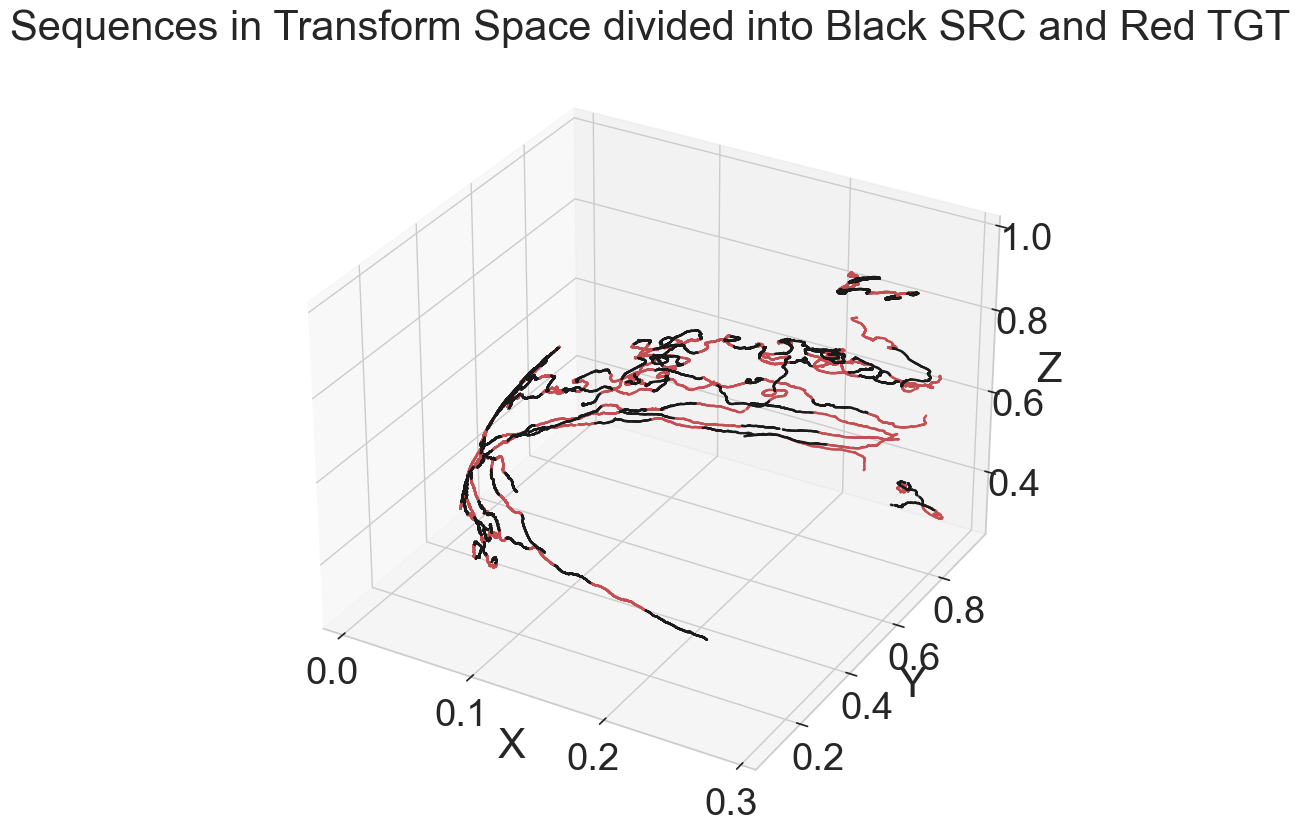

In [23]:
# plot 3D transform
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_src_tgt[0][0:100], y_src_tgt[0][0:100], 
           z_src_tgt[0][0:100], s = 0.5, color ='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plot beaching points in red
ax.scatter(x_src_tgt[1][0:100], y_src_tgt[1][0:100], 
           z_src_tgt[1][0:100], s = 0.5, color ='r')


plt.title('Sequences in Transform Space divided into Black SRC and Red TGT')

In [25]:
# reduce the number of data by taking windows and averaging
def window_avg(data, window_size):
    # reshape the data to facilitate window averaging
    reshaped_data = data[:len(data)//window_size * window_size].reshape(-1, window_size)
    
    # calculate the mean along the last axis
    averaged_data = np.mean(reshaped_data, axis=1)
    
    return averaged_data

# get data from dataframe and apply reduction
window_size = 20 # set window_size

# apply window averaging to src
x_src = [window_avg(sequence, window_size) for sequence in x_src_tgt[0]]
y_src = [window_avg(sequence, window_size) for sequence in y_src_tgt[0]]
z_src = [window_avg(sequence, window_size) for sequence in z_src_tgt[0]]

# apply window averaging to tgt
x_tgt = [window_avg(sequence, window_size) for sequence in x_src_tgt[1]]
y_tgt = [window_avg(sequence, window_size) for sequence in y_src_tgt[1]]
z_tgt = [window_avg(sequence, window_size) for sequence in z_src_tgt[1]]

# combine src x,y,z together, stack, and transpose into shape [sequences, length, x y z]
all_src = np.transpose(np.stack([x_src, y_src, z_src], axis = 0), (1,2,0))
all_tgt = np.transpose(np.stack([x_tgt, y_tgt, z_tgt], axis = 0), (1,2,0))

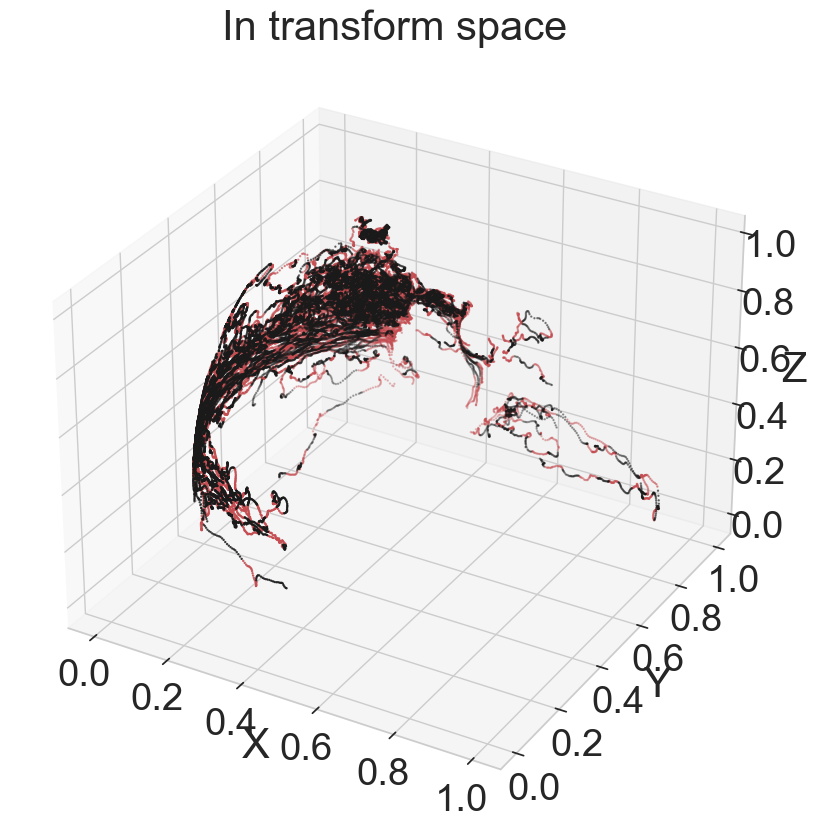

In [27]:
# let's take a look at the output of coordinate transformation, normalization, sequencing, and splitting into src and tgt:
# x
Asia_src_x = all_src[:,:,0]
Asia_tgt_x = all_tgt[:,:,0]

# y
Asia_src_y = all_src[:,:,1]
Asia_tgt_y = all_tgt[:,:,1]

# z
Asia_src_z = all_src[:,:,2]
Asia_tgt_z = all_tgt[:,:,2]

# plot 3D transform
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Asia_src_x, Asia_src_y, 
           Asia_src_z, s = 0.5, color ='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plot beaching points in red
ax.scatter(Asia_tgt_x, Asia_tgt_y, 
           Asia_tgt_z, s = 0.5, color ='r')
plt.title('In transform space')

plt.show()

In [29]:
np.shape(all_src)

(1168, 25, 3)

In [31]:
# split data and input lengths into training and remaining (for validation and testing)
train_src, remaining_src, train_tgt, remaining_tgt = train_test_split(
    all_src, all_tgt, train_size = 1100, random_state = 42)

# split the remaining data and input lengths into validation and test sets
val_src, test_src, val_tgt, test_tgt = train_test_split(
    remaining_src, remaining_tgt, test_size = 34, random_state = 42)

# collate (combine src and tgt into single tensor)
# train
#train_src_collated, train_tgt_collated = collate_fn(train_src), collate_fn(train_tgt)

# val
#val_src_collated, val_tgt_collated = collate_fn(val_src), collate_fn(val_tgt)

# test
#test_src_collated, test_tgt_collated = collate_fn(test_src), collate_fn(test_tgt)

# save as train, val, test of shape:[trajectories (batch), src or tgt, length (of trajectories), x y z (coordinate dimensions)]
training_data = [(torch.tensor(src, dtype=torch.float32), torch.tensor(tgt, dtype=torch.float32)) for src, tgt in zip(train_src, train_tgt)]
validation_data = [(torch.tensor(src, dtype=torch.float32), torch.tensor(tgt, dtype=torch.float32)) for src, tgt in zip(val_src, val_tgt)]
testing_data = [(torch.tensor(src, dtype=torch.float32), torch.tensor(tgt, dtype=torch.float32)) for src, tgt in zip(test_src, test_tgt)]


In [33]:
reshaped_tensor = training_data[0][0].unsqueeze(0)

# Stack the reshaped tensor along the new first dimension
for i in range(1, len(training_data)):
    training_data_src = torch.cat((reshaped_tensor, training_data[i][0].unsqueeze(0)), dim=0)

reshaped_tensor = training_data[0][1].unsqueeze(0)

# Stack the reshaped tensor along the new first dimension
for i in range(1, len(training_data)):
    training_data_tgt = torch.cat((reshaped_tensor, training_data[i][0].unsqueeze(0)), dim=0)

    
reshaped_tensor = validation_data[0][0].unsqueeze(0)
# Stack the reshaped tensor along the new first dimension
for i in range(1, len(testing_data)):
    validation_data_src = torch.cat((reshaped_tensor, validation_data[i][0].unsqueeze(0)), dim=0)
    
reshaped_tensor = validation_data[0][1].unsqueeze(0)
# Stack the reshaped tensor along the new first dimension
for i in range(1, len(testing_data)):
    validation_data_tgt = torch.cat((reshaped_tensor, validation_data[i][0].unsqueeze(0)), dim=0)    
    
reshaped_tensor = testing_data[0][0].unsqueeze(0)
# Stack the reshaped tensor along the new first dimension
for i in range(1, len(testing_data)):
    testing_data_src = torch.cat((reshaped_tensor, testing_data[i][0].unsqueeze(0)), dim=0)
    
reshaped_tensor = testing_data[0][1].unsqueeze(0)
# Stack the reshaped tensor along the new first dimension
for i in range(1, len(testing_data)):
    testing_data_tgt = torch.cat((reshaped_tensor, testing_data[i][0].unsqueeze(0)), dim=0)

batchsize = 1

# split training data and lengths into batches
train_data_batch = torch.split(training_data_src, batchsize)

# split training targets into batches
train_targets_batch = torch.split(training_data_tgt, batchsize)

# length of train_batches_features = total number of batches in the training set
batch_split_num = len(train_data_batch)

### Define vanilla RNN model and set hyperparameters

In [119]:
# let's define our vanilla RNN model:
class drifter_vanilla_RNN(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, nonlinearity, output_size):

        super(drifter_vanilla_RNN, self).__init__()

        # define rnn cell with nonlinearity
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size,
                                num_layers = num_layers, nonlinearity = nonlinearity) # maybe try LSTM/GRU later

        # define fully connected layer to predict next part of target sequence
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, padded_input, hidden_state):
        # pack padded sequence
        #packed_input = rnn_utils.pack_padded_sequence(padded_input, input_lengths, batch_first=True, enforce_sorted=False)
        
        # get output and hidden state through rnn
        output, hidden_state = self.rnn(padded_input, hidden_state)
        
        # unpack output
        #output, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        
        # extract the output from the last time step for each sequence (lat/lon of beaching)
        #final_lat_lon = output[:, -1, :]
        
        # predict the final beaching coordinates
        output = self.fc(output)

        return output, hidden_state.detach()

In [121]:
# define hyperparameters

# Fix random seed
torch.manual_seed(42)

# Define RNN network:
rnn = drifter_vanilla_RNN(input_size = 3, hidden_size = 1028, num_layers = 3,
              output_size = 3, nonlinearity = 'relu')#.cuda()

# Define learning rate, epochs, and batchsize
lr = 0.001
epochs = 50
batchsize = 100

# define loss function
loss_func = torch.nn.MSELoss() # for regression

# use Adam optimizer
optimizer = torch.optim.Adam(rnn.parameters(), lr = lr)

# track training loss and validation loss
train_loss_list = []
val_loss_list = []

## Now, we train the model

In [ ]:
# Let's train our model now (tqdm creates nice progress bar)
for epoch in tqdm.trange(epochs):
    
    # iterate through each batch
    for batch in range(batch_split_num):
    
    
        # initialize hidden_state for each epoch:
        hidden_state = None

        #separate learning for each epoch by initializing optimzer each epoch
        optimizer.zero_grad()

        # pass training inputs through model to get outputs
        train_outputs, hidden_state = rnn(train_data_batch[batch].float(), hidden_state)

        # compute loss
        train_loss = loss_func(train_outputs, train_targets_batch[batch])#.to(device))

        # print training loss
        print('training loss: '+ str(train_loss.item()))

        # save loss for each epoch
        train_loss_list.append(train_loss.item())

        # determine changes needed for each weight/bias for next epoch
        train_loss.backward()

        # apply changes to weights/biases
        optimizer.step()

    # compute validation loss for each epoch: 
    # validation tests model against non-training data to ensure model isn't overfitting to training data
    with torch.no_grad(): # Telling PyTorch we aren't passing inputs to network for training purpose#

        # initialize hidden_state for each epoch:
        hidden_state = None
        
        # apply model to validation data
        val_outputs, val_hidden_state = rnn(validation_data_src.float(), hidden_state)#.to(device))

        # compute validation loss
        val_loss = loss_func(val_outputs, validation_data_tgt)

        # save validation loss for each epoch
        val_loss_list.append(val_loss.item()) 

  0%|          | 0/50 [00:00<?, ?it/s]

training loss: 0.45389607548713684
training loss: 0.4820922911167145


  2%|▏         | 1/50 [00:00<00:23,  2.06it/s]

training loss: 0.2558077871799469
training loss: 0.2677674889564514


  4%|▍         | 2/50 [00:01<00:25,  1.87it/s]

training loss: 0.07705480605363846
training loss: 0.11922665685415268


  6%|▌         | 3/50 [00:01<00:26,  1.77it/s]

training loss: 0.16871300339698792
training loss: 0.15031319856643677


  8%|▊         | 4/50 [00:02<00:27,  1.68it/s]

training loss: 0.12572108209133148
training loss: 0.06732141226530075


 10%|█         | 5/50 [00:02<00:25,  1.76it/s]

training loss: 0.09098100662231445
training loss: 0.08639311790466309


 12%|█▏        | 6/50 [00:03<00:26,  1.65it/s]

training loss: 0.10825558751821518
training loss: 0.10482296347618103


 14%|█▍        | 7/50 [00:04<00:28,  1.53it/s]

training loss: 0.11049304902553558
training loss: 0.09061967581510544


 16%|█▌        | 8/50 [00:04<00:27,  1.51it/s]

training loss: 0.09576322883367538
training loss: 0.06370815634727478


 18%|█▊        | 9/50 [00:05<00:25,  1.58it/s]

training loss: 0.08368129283189774
training loss: 0.056610800325870514


 20%|██        | 10/50 [00:06<00:25,  1.57it/s]

training loss: 0.08661288022994995
training loss: 0.0688289925456047


 22%|██▏       | 11/50 [00:06<00:25,  1.54it/s]

training loss: 0.08298740535974503
training loss: 0.0635470449924469


 24%|██▍       | 12/50 [00:07<00:24,  1.56it/s]

training loss: 0.06689285486936569
training loss: 0.05118466541171074


 26%|██▌       | 13/50 [00:08<00:24,  1.51it/s]

training loss: 0.05885504558682442
training loss: 0.046908389776945114


 28%|██▊       | 14/50 [00:08<00:24,  1.48it/s]

training loss: 0.057276174426078796
training loss: 0.04069420322775841


 30%|███       | 15/50 [00:09<00:24,  1.44it/s]

training loss: 0.05207093432545662
training loss: 0.0269110556691885


 32%|███▏      | 16/50 [00:10<00:24,  1.42it/s]

training loss: 0.0414142906665802
training loss: 0.014145752415060997


 34%|███▍      | 17/50 [00:11<00:23,  1.40it/s]

training loss: 0.02986944280564785
training loss: 0.010389196686446667


 36%|███▌      | 18/50 [00:11<00:22,  1.43it/s]

training loss: 0.017654499039053917
training loss: 0.006993381772190332


 38%|███▊      | 19/50 [00:12<00:21,  1.41it/s]

training loss: 0.006575509440153837
training loss: 0.001418129657395184


 40%|████      | 20/50 [00:13<00:20,  1.49it/s]

training loss: 0.0006659841747023165
training loss: 0.00068525510141626


 42%|████▏     | 21/50 [00:13<00:19,  1.47it/s]

training loss: 0.000750220671761781
training loss: 0.0029064854606986046


 44%|████▍     | 22/50 [00:14<00:19,  1.47it/s]

training loss: 0.003966368269175291
training loss: 0.00257841101847589


 46%|████▌     | 23/50 [00:15<00:17,  1.54it/s]

training loss: 0.006887892726808786
training loss: 0.0010192340705543756


 48%|████▊     | 24/50 [00:15<00:17,  1.52it/s]

training loss: 0.006478393916040659
training loss: 0.00044296999112702906


 50%|█████     | 25/50 [00:16<00:16,  1.51it/s]

training loss: 0.0030465975869446993
training loss: 0.0003237931814510375


 52%|█████▏    | 26/50 [00:16<00:15,  1.52it/s]

training loss: 0.0005577999399974942
training loss: 0.0002057080710073933


 54%|█████▍    | 27/50 [00:17<00:14,  1.54it/s]

training loss: 0.0007783058099448681
training loss: 0.00020407643751241267


 56%|█████▌    | 28/50 [00:18<00:14,  1.50it/s]

training loss: 0.001583790173754096
training loss: 0.00038277145358733833


 58%|█████▊    | 29/50 [00:18<00:13,  1.51it/s]

training loss: 0.0016713043441995978
training loss: 0.0006242304807528853


 60%|██████    | 30/50 [00:19<00:13,  1.54it/s]

training loss: 0.001316587207838893
training loss: 0.00046616335748694837


 62%|██████▏   | 31/50 [00:20<00:12,  1.54it/s]

training loss: 0.0007347826031036675
training loss: 0.00019399913435336202


 64%|██████▍   | 32/50 [00:20<00:11,  1.57it/s]

In [ ]:
# let's visualize the training and validation loss
print('final training loss: '+ str(train_loss_list[-1]))
print('final validation loss: '+ str(val_loss_list[-1]))

plt.figure(figsize = (15, 9))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(val_loss_list, linewidth = 3, label = 'Validation Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

## let's test our model with our test data now!

In [ ]:
# activate no_grad() since we aren't performing backprop: testing not training
with torch.no_grad():
    
    # initialize hidden state for the encoder:
    hidden_state = None
    
    # pass training inputs through model to get outputs
    test_outputs, hidden_state = rnn(testing_data_src.float(), hidden_state)
    
    # compute loss
    test_loss = loss_func(test_outputs, testing_data_tgt)
print(test_loss.item())

### to convert back to lat/lon coordinates and visualize where the model predicted beaching, we need to perform the inveres of the coord_transform_normalize function on the test output

In [ ]:
# we define a function to transform normalized x,y,z output to lat/lon coordinates
def inverse_coord_transform_normalize(model_outputs):
    
    lon_list = []
    lat_list = []
    for sequence in model_outputs:
        for coord in sequence:
            # convert from tensor to list of lists
            model_outputs_list = model_outputs.tolist()

            # undo MinMaxScaler normalization
            model_outputs_denorm = [coord_scaler.inverse_transform(np.array(xyz_norm_coords).reshape(-1, 3))
                for xyz_norm_coords in model_outputs_list]

            x = [coord[0][0] for coord in model_outputs_denorm]
            y = [coord[0][1] for coord in model_outputs_denorm]
            z = [coord[0][2] for coord in model_outputs_denorm]


            lons = np.degrees(np.arctan2(y, x))
            lats = np.degrees(np.arcsin(z))
            
            lon_list.append(lons)
            lat_list.append(lats)
    #print(lon_list)

    return lat_list, lon_list

In [ ]:
# convert x,y,z normalized outputs to denormalized lat/lon coords
lat_outputs, lon_outputs = inverse_coord_transform_normalize(test_outputs)

# convert x,y,z normalized targets to denormalized lat/lon coords
lat_targets, lon_targets = inverse_coord_transform_normalize(testing_data_tgt)

# plot model outputs vs. targets
beach = Asia
beaching_points = Asia.drop_duplicates(subset='id', keep='last')

point_size = 100

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()

# Scatter plot with colors based on the custom colormap
# model outputs
scatter_targets = ax.scatter(
    lon_outputs,
    lat_outputs,
    marker='o',
    c='b',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=1
)

# targets
scatter_targets = ax.scatter(
    lon_targets,
    lat_targets,
    marker='o',
    c='r',
    transform=ccrs.PlateCarree(),  # Specify the coordinate reference system
    s=point_size,
    alpha=1
)

plt.title('model outputs vs. targets', fontsize = 30)
plt.show()

# Clearly this is very off. Too bad, perhaps an LSTM/GRU or transformer would work better. Coming soon...